In [1]:
using System;
using System.Threading;

class DefiniteIntegral
{
    private static object lockObject = new object();

    public static double Solve(double a, double b, Func<double, double> function, double step, int threadsnumber)
    {
        double result = 0.0;
        double intervalWidth = (b - a) / threadsnumber;
        ManualResetEvent[] doneThread = new ManualResetEvent[threadsnumber];

        for (int i = 0; i < threadsnumber; i++)
        {
            doneThread[i] = new ManualResetEvent(false);
            int threadIndex = i;
            ThreadPool.QueueUserWorkItem((state) =>
            {
                double startPoint = a + threadIndex * intervalWidth;
                double endPoint = startPoint + intervalWidth;
                double sum = (function(startPoint) + function(endPoint)) / 2.0;

                for (double x = startPoint + step / 2; x < endPoint; x += step / 2)
                {
                    sum += function(x);
                }

                sum *= step / 2;

                lock (lockObject)
                {
                    result += sum;
                }

                doneThread[threadIndex].Set();
            });
        }

        WaitHandle.WaitAll(doneThread);

        return result;
    }

    public static double SolveNoMulti(double a, double b, Func<double, double> function, double step)
    {
        int n = Convert.ToInt32((b - a) / step);

        double result = function(a) + function(b);
        for (int i = 0; i < n; i++)
            result += 2 * function((double)(a + i * step));

        return result * (step / 2);
    }
}

In [2]:
#r "nuget: xunit, 2.8.1"

using Xunit;

var X = (double x) => x;
var SIN = (double x) => Math.Sin(x);

Assert.Equal(0, DefiniteIntegral.Solve(-1, 1, X, 1e-4, 2), 1e-4);

Assert.Equal(0, DefiniteIntegral.Solve(-1, 1, SIN, 1e-5, 8), 1e-4);

Assert.Equal(50, DefiniteIntegral.Solve(0, 10, X, 1e-6, 8), 1e-5);

Installed Packages xunit, 2.8.1

Installed Packages ScottPlot, 5.0.36

0 потоков - 15ms - 100%
1 поток - 35ms - 223,9%
2 потока - 18ms - 117,61%
3 потока - 12ms - 77,36%
4 потока - 9ms - 60,38%
5 потоков - 8ms - 55,97%
6 потоков - 8ms - 52,2%
7 потоков - 7ms - 49,06%
8 потоков - 7ms - 44,03%
9 потоков - 8ms - 52,83%
10 потоков - 7ms - 49,06%
11 потоков - 6ms - 43,4%
12 потоков - 10ms - 65,41%
13 потоков - 8ms - 50,94%
14 потоков - 6ms - 42,77%
15 потоков - 6ms - 42,77%
16 потоков - 7ms - 47,17%
17 потоков - 7ms - 49,06%
18 потоков - 9ms - 61,01%
19 потоков - 7ms - 49,06%
20 потоков - 9ms - 59,12%
21 поток - 8ms - 52,2%
22 потока - 6ms - 43,4%
23 потока - 6ms - 40,25%
24 потока - 6ms - 40,88%
25 потоков - 6ms - 40,25%
26 потоков - 6ms - 38,99%
27 потоков - 6ms - 40,25%
28 потоков - 6ms - 38,99%
29 потоков - 6ms - 38,36%
30 потоков - 6ms - 39,62%
31 поток - 8ms - 54,09%
32 потока - 6ms - 37,74%
33 потока - 6ms - 39,62%
34 потока - 6ms - 39,62%
35 потоков - 6ms - 38,99%
36 потоков - 6ms - 41,51%
37 потоков - 6ms - 39,62%
38 потоков - 7ms - 44,65%
39 потоков 


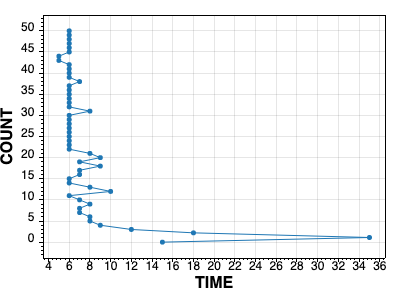

In [6]:
#r "nuget:ScottPlot, 5.0.36"
using System;
using System.Diagnostics;
using System.Linq;
using Microsoft.DotNet.Interactive.Formatting;

class DefiniteIntegralOneThread
{
    public static double Solve(double a, double b, Func<double, double> function, double step)
    {
        double result = 0.0;
        result += (function.Invoke(a) + function.Invoke(b)) / 2;

        int steps = (int)Math.Round((b - a) / step);
        for (int i = 1; i < steps; i++)
        {
            result += function.Invoke(a + i * step);
        }

        return result * step;
    }
}


public static string NumWord(int value, string[] words)
{
    value = Math.Abs(value) % 100;
    int num = value % 10;
    if (value > 10 && value < 20) return words[2];
    if (num > 1 && num < 5) return words[1];
    if (num == 1) return words[0];
    return words[2];
}

Formatter.Register(
    typeof(ScottPlot.Plot), 
    (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), 
    HtmlFormatter.MimeType
);

int maxThreadCount = 51;
int callCount = 10;

int[] elapsedMillisecondsForThreads = new int[maxThreadCount];
int[] threadCounts = new int[maxThreadCount];

for (int currentThreadCount = 0; currentThreadCount < maxThreadCount; currentThreadCount++)
{
    threadCounts[currentThreadCount] = currentThreadCount;

    Stopwatch timer = new Stopwatch();

    for (int currentCall = 0; currentCall < callCount; currentCall++)
    {
        timer.Start();

        double result = currentThreadCount == 0
            ? DefiniteIntegralOneThread.Solve(-100, 100, SIN, 1e-4)
            : DefiniteIntegral.Solve(-100, 100, SIN, 1e-4, currentThreadCount);

        timer.Stop();
    }

    elapsedMillisecondsForThreads[currentThreadCount] = (int)timer.ElapsedMilliseconds;
}

ScottPlot.Plot plt = new();
plt.Add.Scatter(
    elapsedMillisecondsForThreads.Select(m => m / callCount).ToArray(), 
    threadCounts.Select(t => t == 1 ? t + 0.1 : t == 2 ? t + 0.2 : t).ToArray()
);

plt.XLabel("TIME");
plt.YLabel("COUNT");

string[] wordForms = {"поток", "потока", "потоков"};

for (int i = 0; i < maxThreadCount; i++)
{
    string declension = NumWord(i, wordForms);
    double percentage;
    if (i == 0)
    {
        percentage = 100;
    }
    else
    {
        percentage = (double)elapsedMillisecondsForThreads[i] / elapsedMillisecondsForThreads[0] * 100;
    }
    Console.WriteLine($"{i} {declension} - {elapsedMillisecondsForThreads[i] / callCount}ms - {Math.Round(percentage, 2)}%");
}

Console.WriteLine();
Console.WriteLine($"0 потоков - {elapsedMillisecondsForThreads[0] / callCount}ms - 100%");

int optimalThreadCount = 50;
string declension = NumWord(optimalThreadCount, wordForms);
Console.WriteLine($"{optimalThreadCount} {declension} - {elapsedMillisecondsForThreads[optimalThreadCount] / callCount}ms - {Math.Round((double)elapsedMillisecondsForThreads[optimalThreadCount] / elapsedMillisecondsForThreads[0] * 100, 2)}%");

plt

## Summary

**Выбранный шаг: 1e-4**

**Оптимальное кол-во потоков: 10**     
**Средняя скорость быстрее однопоточного вычисления на 81,3%**
